In [11]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab Notebooks/Datasets/255-Datasets/data-prep-assignment


base_path = 'covid-xray-image-classification/'
train_path = base_path + 'train/'
test_path = base_path + 'test/'



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/Datasets/255-Datasets/data-prep-assignment


In [25]:
%ls


covid-xray-image-classification/  spatio-temporal-pollution/
emotional-speech-audio/           tabular-nyctaxi/
human-action-recognition-video/   timeseries-residential-power-usage/


# EDA

Random Sample of Images

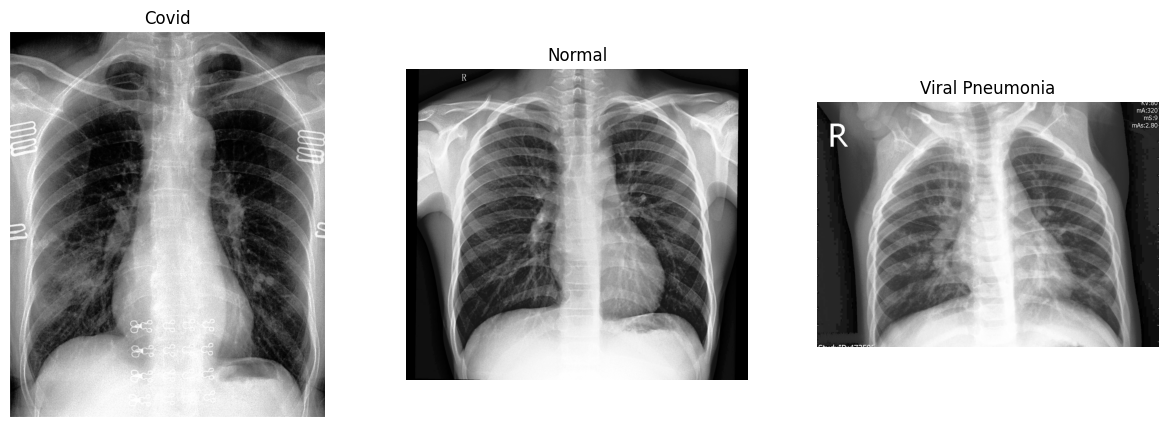

In [15]:
import os
import random
import matplotlib.pyplot as plt
import cv2

categories = ['Covid', 'Normal', 'Viral Pneumonia']

plt.figure(figsize=(15, 5))
for i, category in enumerate(categories):
    plt.subplot(1, 3, i+1)
    random_img_path = random.choice(os.listdir(train_path + category))
    img = cv2.imread(train_path + category + '/' + random_img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert from BGR to RGB
    plt.imshow(img)
    plt.title(category)
    plt.axis('off')
plt.show()

In [16]:
for category in categories:
    print(f"Number of {category} images in training set: {len(os.listdir(train_path + category))}")

Number of Covid images in training set: 111
Number of Normal images in training set: 70
Number of Viral Pneumonia images in training set: 70


# Data Prep

Keracv performs image resizing, data augmentation, data normalization, and label encoding

In [17]:
from keras.preprocessing.image import ImageDataGenerator

BATCH_SIZE = 32
IMG_SIZE = (224, 224)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 251 images belonging to 3 classes.
Found 66 images belonging to 3 classes.


# Model Building

Base CNN

In [18]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(224, 224, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(3))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 activation (Activation)     (None, 222, 222, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 activation_1 (Activation)   (None, 109, 109, 64)      0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                   

Train Base Model

In [19]:
EPOCHS = 20

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=test_generator,
    validation_steps=test_generator.samples // BATCH_SIZE
)

Epoch 1/20
7/7 [==============================] - 96s 14s/step - loss: 1.6787 - accuracy: 0.3242 - val_loss: 1.0792 - val_accuracy: 0.5938
Epoch 2/20
7/7 [==============================] - 32s 4s/step - loss: 1.0753 - accuracy: 0.4732 - val_loss: 0.9431 - val_accuracy: 0.7344
Epoch 3/20
7/7 [==============================] - 31s 4s/step - loss: 0.8875 - accuracy: 0.6339 - val_loss: 0.8469 - val_accuracy: 0.6250
Epoch 4/20
7/7 [==============================] - 31s 4s/step - loss: 0.7884 - accuracy: 0.6438 - val_loss: 0.7414 - val_accuracy: 0.6250
Epoch 5/20
7/7 [==============================] - 33s 4s/step - loss: 0.7014 - accuracy: 0.6804 - val_loss: 0.5109 - val_accuracy: 0.7969
Epoch 6/20
7/7 [==============================] - 31s 4s/step - loss: 0.6423 - accuracy: 0.7260 - val_loss: 0.5433 - val_accuracy: 0.7969
Epoch 7/20
7/7 [==============================] - 31s 4s/step - loss: 0.6685 - accuracy: 0.7123 - val_loss: 0.5274 - val_accuracy: 0.8125
Epoch 8/20
7/7 [=================

Visualize Results

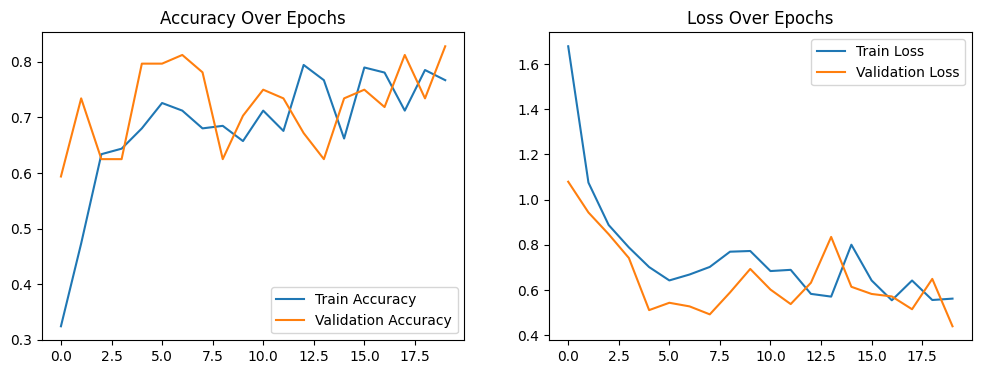

In [20]:
# Plotting training accuracy and loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Over Epochs')

plt.show()

Use pre-trained model

In [21]:
from keras.applications import VGG16

# Load the VGG16 model, excluding the top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

58889256/58889256 [==============================] - 0s 0us/step


In [22]:
for layer in base_model.layers:
    layer.trainable = False


In [23]:
from keras.models import Model
from keras.layers import GlobalAveragePooling2D

x = base_model.output
x = GlobalAveragePooling2D()(x)  # This layer is a form of downsampling that works well with transfer learning
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(3, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [24]:
EPOCHS = 20

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=test_generator,
    validation_steps=test_generator.samples // BATCH_SIZE
)

Epoch 1/20
7/7 [==============================] - 170s 25s/step - loss: 1.0650 - accuracy: 0.4475 - val_loss: 0.8967 - val_accuracy: 0.4375
Epoch 2/20
7/7 [==============================] - 167s 25s/step - loss: 0.8896 - accuracy: 0.6027 - val_loss: 0.7674 - val_accuracy: 0.7812
Epoch 3/20
7/7 [==============================] - 166s 24s/step - loss: 0.8182 - accuracy: 0.6347 - val_loss: 0.6423 - val_accuracy: 0.9062
Epoch 4/20
7/7 [==============================] - 160s 23s/step - loss: 0.7240 - accuracy: 0.6575 - val_loss: 0.5883 - val_accuracy: 0.9219
Epoch 5/20
7/7 [==============================] - 169s 25s/step - loss: 0.6635 - accuracy: 0.7054 - val_loss: 0.5587 - val_accuracy: 0.7969
Epoch 6/20
7/7 [==============================] - 166s 24s/step - loss: 0.5761 - accuracy: 0.7900 - val_loss: 0.5261 - val_accuracy: 0.8750
Epoch 7/20
7/7 [==============================] - 159s 23s/step - loss: 0.5866 - accuracy: 0.8174 - val_loss: 0.4666 - val_accuracy: 0.8906
Epoch 8/20
7/7 [====

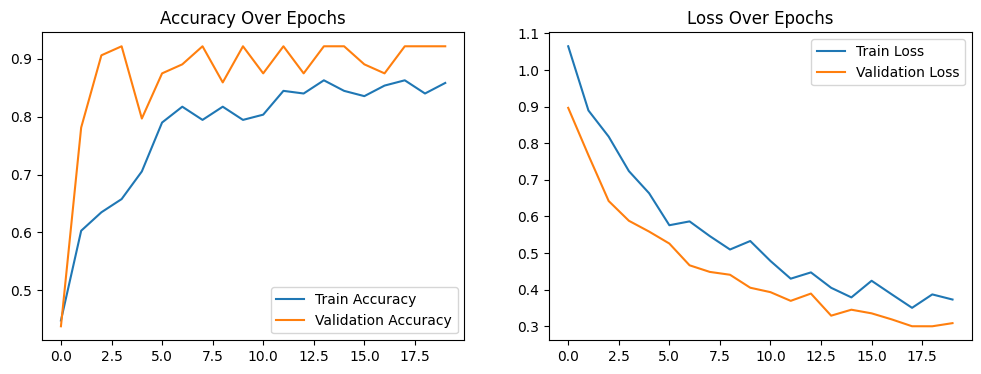

In [26]:
# Plotting training accuracy and loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Over Epochs')

plt.show()